All import

In [1]:
import librosa as lb
import scipy
import scipy.fftpack as fft
from scipy.signal import get_window
import librosa.display as display
import librosa.effects as effects
import numpy as np
import csv as csv
import os
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from numpy import genfromtxt

defining pre_processing

In [3]:

def pre_processing(path):
  #load
  audio, sr = lb.load(path = path, mono = True)

  #pre-emp
  pre_emp_audio = effects.preemphasis(audio, 0.97)


  #removing silence in audio
  clips = effects.split(pre_emp_audio, top_db=25)
  silenced=[]
  for c in clips:
    data = audio[c[0]: c[1]]
    silenced.extend(data)

  silence = np.array(silenced)



  return silence, sr

EXAMPLE_PATH = "/home/axel1143/Scrivania/Voxceleb_wav/wav/id10261/1suWlhhvRcs/00011.wav"
BASE_TRAINING_PATH="/home/axel1143/Scrivania/Voxceleb_wav/wav/"
BASE_PATH = "C:\\Users\\alexp\\Desktop\\Voxceleb_wav\\"

**(example)** calculating mfcc, delta, delta2

In [4]:
processed_audio, sr = pre_processing(EXAMPLE_PATH)
print(len(processed_audio)/sr)
mfcc = lb.feature.mfcc(y = processed_audio, sr = sr, n_mfcc = 13)
mfcc_delta = lb.feature.delta(mfcc)
mfcc_delta2 = lb.feature.delta(mfcc, order = 2)

Audio(processed_audio, rate = sr)



20.271020408163267


/tmp/ipykernel_16395/3605190324.py:6: FutureWarning: Pass coef=0.97 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pre_emp_audio = effects.preemphasis(audio, 0.97)


**(example)** show mfcc, delta & delta2

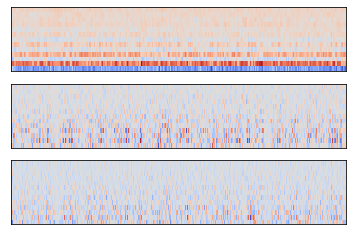

In [ ]:
fig, ax = plt.subplots(nrows =3, sharex =True)

img_mfcc = display.specshow(mfcc, ax=ax[0])

img_delta = display.specshow(mfcc_delta, ax=ax[1])

img_delta2 = display.specshow(mfcc_delta2, ax=ax[2])



**(example)** single execution example

In [ ]:
row_csv = []
row_csv.append("id11")
row_csv.append("pathblablabla")
print(row_csv)
for row in mfcc:
  row_csv_2 = []
  for value in row:
    row_csv_2.append(value)
  row_csv.append(row_csv_2)

for row in mfcc_delta:
  row_csv_2 = []
  for value in row:
    row_csv_2.append(value)
  row_csv.append(row_csv_2)

for row in mfcc_delta2:
  row_csv_2 = []
  for value in row:
    row_csv_2.append(value)
  row_csv.append(row_csv_2)

header = ["id","path",
          "mfcc1","mfcc2","mfcc3","mfcc4","mfcc5","mfcc6","mfcc7","mfcc8","mfcc9","mfcc10","mfcc11","mfcc12","mfcc13",
          "delta1","delta2","delta3","delta4","delta5","delta6","delta7","delta8","delta9","delta10","delta11","delta12","delta13",
          "delta2_1","delta2_2","delta2_3","delta2_4","delta2_5","delta2_6","delta2_7","delta2_8","delta2_9","delta2_10","delta2_11","delta2_12","delta2_13"]

with open("/content/drive/MyDrive/DATASET_VOXCELEB_1/file.csv", "w", encoding="UTF-8", newline="") as cs:
  writer = csv.writer(cs)
  writer.writerow(header)
  writer.writerow(row_csv)



**creating** csv


In [ ]:
header = ["id","path",
          "mfcc1","mfcc2","mfcc3","mfcc4","mfcc5","mfcc6","mfcc7","mfcc8","mfcc9","mfcc10","mfcc11","mfcc12","mfcc13",
          "delta1","delta2","delta3","delta4","delta5","delta6","delta7","delta8","delta9","delta10","delta11","delta12","delta13", 
          "delta2_1","delta2_2","delta2_3","delta2_4","delta2_5","delta2_6","delta2_7","delta2_8","delta2_9","delta2_10","delta2_11","delta2_12","delta2_13"]

with open(BASE_PATH + "id_mfcc_deltas_ridotto.csv", "w", encoding="UTF-8", newline="") as writefile:
  writer = csv.writer(writefile)
  writer.writerow(header)
  counter_speaker = 0
  for dir in os.listdir(BASE_TRAINING_PATH):
    if counter_speaker < 300:
        counter_speaker+=1
        count_audio = 0
        for dir1 in os.listdir(BASE_TRAINING_PATH+dir):
            if count_audio < 40:
                for file in os.listdir(BASE_TRAINING_PATH+dir+"/"+dir1):
                  if count_audio < 40:
                      if not os.path.isdir(BASE_TRAINING_PATH+dir+"/"+dir1+"/"+file):
                        count_audio +=1
                        COMPLETE_PATH = BASE_TRAINING_PATH+dir+"/"+dir1+"/"+file
                        processed_audio, sr = pre_processing(COMPLETE_PATH)

                        #mfcc = get_mfcc_coefficient(processed_audio, rs) #my mfcc
                        mfcc = lb.feature.mfcc(y = processed_audio, sr = sr, n_mfcc=13)
                        mfcc_delta = lb.feature.delta(mfcc)
                        mfcc_delta2 = lb.feature.delta(mfcc, order=2)

                        row_csv = []
                        row_csv.append(dir)
                        row_csv.append(COMPLETE_PATH)


                        for row in mfcc:
                          row_csv_2 = []
                          for value in row:
                            row_csv_2.append(value)
                          row_csv.append(row_csv_2)

                        for row in mfcc_delta:
                          row_csv_2 = []
                          for value in row:
                            row_csv_2.append(value)
                          row_csv.append(row_csv_2)

                        for row in mfcc_delta2:
                          row_csv_2 = []
                          for value in row:
                            row_csv_2.append(value)
                          row_csv.append(row_csv_2)

                        writer.writerow(row_csv)

        print(counter_speaker)
    else:
        continue

loading df

In [7]:
df = pd.read_csv(BASE_PATH + "id_mfcc_deltas_ridotto.csv")

mfcc dataset con esplosione coefficienti

In [8]:
features_mfcc = ["mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8", "mfcc9", "mfcc10", "mfcc11",
            "mfcc12", "mfcc13"]

labels = df.loc[:, ["id"]].values #labael dataset
features_mfcc_values = df.loc[:, features_mfcc].values #mfcc dataset

del df

total = features_mfcc_values.shape[0] * features_mfcc_values.shape[1]
counter = 0
correct_dataset_mfcc = []
header = []

with open(BASE_PATH + "id_mfcc_solo_ridotto.csv", "w", encoding="UTF-8", newline="") as writefile:
    writer = csv.writer(writefile)
    for i in range(features_mfcc_values.shape[0]): #
        row_dataset = []
        #row_dataset.append(labels[i])
        for j in range(features_mfcc_values.shape[1]):
            features_mfcc_values[i][j] = features_mfcc_values[i][j].split()
            for k in range(len(features_mfcc_values[i][j])):
                features_mfcc_values[i][j][k] = features_mfcc_values[i][j][k].replace("[", "")
                features_mfcc_values[i][j][k] = features_mfcc_values[i][j][k].replace("]", "")
                features_mfcc_values[i][j][k] = features_mfcc_values[i][j][k].replace(",", "")
            for ele in features_mfcc_values[i][j]:
                if ele == "":
                    features_mfcc_values[i][j].remove(ele)
            for k in range(len(features_mfcc_values[i][j])):
                features_mfcc_values[i][j][k] = float(features_mfcc_values[i][j][k])
                row_dataset.append(features_mfcc_values[i][j][k])
        correct_dataset_mfcc.append(row_dataset)
        counter += 1
        print(counter, "/", features_mfcc_values.shape[0])

    len_max = 0
    for row in correct_dataset_mfcc:
        if len(row) > len_max:
            len_max = len(row)

    for i in range(len_max):
        header.append("mfcc_" + str(i))

    print(len_max)

    writer.writerow(header)
    writer.writerows(correct_dataset_mfcc)

del correct_dataset_mfcc
del features_mfcc_values

NameError: name 'df' is not defined

(ricontrollare) delta dataset con esplosione coefficienti

In [ ]:

features_delta = ["delta1", "delta2", "delta3", "delta4", "delta5", "delta6", "delta7", "delta8", "delta9", "delta10",
            "delta11", "delta12", "delta13"]

labels = df.loc[:, ["id"]].values #labael dataset
features_delta_values = df.loc[:, features_delta].values #delta dataset

del df

total = features_delta_values.shape[0] * features_delta_values.shape[1]
counter = 0
correct_dataset_delta = []
header = []

with open(BASE_PATH + "id_delta_solo_ridotto.csv", "w", encoding="UTF-8", newline="") as writefile:
    writer = csv.writer(writefile)
    for i in range(features_delta_values.shape[0]):
        row_dataset = []
        for j in range(features_delta_values.shape[1]):
            features_delta_values[i][j] = features_delta_values[i][j].split()
            for k in range(len(features_delta_values[i][j])):
                features_delta_values[i][j][k] = features_delta_values[i][j][k].replace("[", "")
                features_delta_values[i][j][k] = features_delta_values[i][j][k].replace("]", "")
                features_delta_values[i][j][k] = features_delta_values[i][j][k].replace(",", "")
            for ele in features_delta_values[i][j]:
                if ele == "":
                    features_delta_values[i][j].remove(ele)
            for k in range(len(features_delta_values[i][j])):
                features_delta_values[i][j][k] = float(features_delta_values[i][j][k])
                row_dataset.append(features_delta_values[i][j][k])

        counter += 1
        correct_dataset_delta.append(row_dataset)
        print(counter, "/", features_delta_values.shape[0])

    len_max = 0
    for row in correct_dataset_delta:
        if len(row) > len_max:
            len_max = len(row)

    for i in range(len_max):
        header.append("delta_" + str(i))

    print(len_max)

    writer.writerow(header)
    writer.writerows(correct_dataset_delta)

del correct_dataset_delta
del features_delta_values


(ricontrollare) delta2 dataset con esplosione coefficienti

In [1]:
features_delta2 = ["delta2_1", "delta2_2", "delta2_3", "delta2_4", "delta2_5", "delta2_6", "delta2_7", "delta2_8", "delta2_9",
            "delta2_10", "delta2_11", "delta2_12", "delta2_13"]

labels = df.loc[:, ["id"]].values #labael dataset
features_delta2_values = df.loc[:, features_delta2].values #delta2 dataset

del df
header = []
with open(BASE_PATH + "id_delta2_solo_ridotto.csv", "w", encoding="UTF-8", newline="") as writefile:
    writer = csv.writer(writefile)

    total = features_delta2_values.shape[0] * features_delta2_values.shape[1]
    counter = 0
    correct_dataset_delta2 = []
    for i in range(features_delta2_values.shape[0]):
        row_dataset = []
        for j in range(features_delta2_values.shape[1]):
            features_delta2_values[i][j] = features_delta2_values[i][j].split()
            for k in range(len(features_delta2_values[i][j])):
                features_delta2_values[i][j][k] = features_delta2_values[i][j][k].replace("[", "")
                features_delta2_values[i][j][k] = features_delta2_values[i][j][k].replace("]", "")
                features_delta2_values[i][j][k] = features_delta2_values[i][j][k].replace(",", "")
            for ele in features_delta2_values[i][j]:
                if ele == "":
                    features_delta2_values[i][j].remove(ele)
            for k in range(len(features_delta2_values[i][j])):
                features_delta2_values[i][j][k] = float(features_delta2_values[i][j][k])
                row_dataset.append(features_delta2_values[i][j][k])\

        counter += 1
        correct_dataset_delta2.append(row_dataset)
        print(counter, "/", features_delta2_values.shape[0])

    len_max = 0
    for row in correct_dataset_delta2:
        if len(row) > len_max:
            len_max = len(row)

    for i in range(len_max):
        header.append("delta2_" + str(i))

    print(len_max)

    writer.writerow(header)
    writer.writerows(correct_dataset_delta2)

del correct_dataset_delta2
del features_delta2_values

NameError: name 'df' is not defined

mfcc riempiti con media

In [3]:
mfcc = pd.read_csv(BASE_PATH + "id_mfcc_solo_ridotto.csv")
print("loaded csv")
df_mfcc = pd.DataFrame(mfcc)
print("dataframe completed")
del mfcc

imp_mean = SimpleImputer(missing_values=np.nan,  strategy="mean")
filled = imp_mean.fit_transform(df_mfcc)
"""
del df_mfcc
print("imputer complete")
df_mfcc_scalar = StandardScaler().fit_transform(filled)
del filled
print("scalar complete")
complete = pd.DataFrame(df_mfcc_scalar)
print(complete.head())
del df_mfcc_scalar

pca = PCA(n_components=10000) #38% of total
pca_c = pca.fit_transform(complete)
pca_df = pd.DataFrame(pca_c)
print("pca complete, saving...")
pca_df.to_csv(BASE_PATH + 'pca_mfcc.csv', index=False)
"""
completed = pd.DataFrame(filled)
completed.to_csv(BASE_PATH+ 'mfcc_filled_mean.csv', index=False)

loaded csv
dataframe completed


AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

(ricontrollare)

In [4]:
delta = pd.read_csv(BASE_PATH + "id_delta_solo_ridotto.csv")
print("loaded csv")
df_delta = pd.DataFrame(delta)
print("dataframe completed")
del delta

imp_mean = SimpleImputer(missing_values=np.nan,  strategy="mean")
filled = imp_mean.fit_transform(df_delta)
del df_delta
print("imputer complete")
df_delta_scalar = StandardScaler().fit_transform(filled)

del filled
print("scalar complete")
complete = pd.DataFrame(df_delta_scalar)
print(complete.head())
del df_delta_scalar

pca = PCA(n_components=10000) #38% of total
pca_c = pca.fit_transform(complete)
pca_df = pd.DataFrame(pca_c)
print("pca complete, saving...")
pca_df.to_csv(BASE_PATH + 'pca_delta.csv', index=False)

loaded csv
dataframe completed
imputer complete
scalar complete
      0         1         2         3         4         5         6      \
0  0.411088  0.411088  0.411088  0.411088  0.411088  0.418801  0.325762   
1  0.260956  0.260956  0.260956  0.260956  0.260956 -0.421026 -1.054875   
2  1.526943  1.526943  1.526943  1.526943  1.526943  2.099711  2.134955   
3  0.096801  0.096801  0.096801  0.096801  0.096801 -0.255742 -0.375684   
4 -0.309905 -0.309905 -0.309905 -0.309905 -0.309905 -0.395612 -0.636542   

      7         8         9      ...         29942         29943  \
0  0.420239  0.650295  0.923398  ... -2.220446e-16 -4.440892e-16   
1 -1.226583 -1.118363 -0.791528  ... -2.220446e-16 -4.440892e-16   
2  1.975086  1.510796  0.704531  ... -2.220446e-16 -4.440892e-16   
3 -0.287850 -0.023649  0.322992  ... -2.220446e-16 -4.440892e-16   
4 -0.682782 -0.589117 -0.669538  ... -2.220446e-16 -4.440892e-16   

          29944  29945  29946  29947  29948  29949  29950  29951  
0 -2.7755

(ricontrollare)

In [3]:
delta2 = pd.read_csv(BASE_PATH + "id_delta2_solo_ridotto.csv")
print("loaded csv")
df_delta2 = pd.DataFrame(delta2)
print("dataframe completed")
del delta2

imp_mean = SimpleImputer(missing_values=np.nan,  strategy="mean")
filled = imp_mean.fit_transform(df_delta2)
del df_delta2
print("imputer complete")
df_delta2_scalar = StandardScaler().fit_transform(filled)

del filled
print("scalar complete")
complete = pd.DataFrame(df_delta2_scalar)
print(complete.head())
del df_delta2_scalar

pca = PCA(n_components=10000) #38% of total
pca_c = pca.fit_transform(complete)
pca_df = pd.DataFrame(pca_c)
print("pca complete, saving...")
pca_df.to_csv(BASE_PATH + 'pca_delta2.csv', index=False)

loaded csv
dataframe completed
imputer complete
scalar complete
      0         1         2         3         4         5         6      \
0  0.050967  0.050967  0.050967  0.050967  0.050967 -0.295921 -0.350847   
1 -0.949634 -0.949634 -0.949634 -0.949634 -0.949634 -1.382515 -1.028725   
2  1.251872  1.251872  1.251872  1.251872  1.251872  0.777319 -0.202126   
3 -0.408204 -0.408204 -0.408204 -0.408204 -0.408204  0.045465  0.143373   
4 -0.048549 -0.048549 -0.048549 -0.048549 -0.048549 -0.545222 -0.640399   

      7         8         9      ...         29942         29943  29944  \
0 -0.041145  0.474151  0.888834  ...  1.110223e-16  2.220446e-16    0.0   
1 -0.230363  0.622840  1.150390  ...  1.110223e-16  2.220446e-16    0.0   
2 -1.051790 -1.546010 -1.490307  ...  1.110223e-16  2.220446e-16    0.0   
3 -0.020074  0.153925  0.593651  ...  1.110223e-16  2.220446e-16    0.0   
4 -0.097056  0.368910  0.311422  ...  1.110223e-16  2.220446e-16    0.0   

          29945         29946     

vector quantization con kmeans

In [ ]:
from sklearn.cluster import KMeans

Y = np.array(pd.read_csv(BASE_PATH + "mfcc_filled_mean.csv"))
X = Y.reshape((-1, 1))

kmeans = KMeans(n_clusters=10, n_init=5)
kmeans.fit(X)

mfcc_shape = Y.shape
np.random.seed(0)

values = kmeans.cluster_centers_.squeeze()
lables = kmeans.labels_

mfcc_compressed = np.choose(lables, values)
mfcc_compressed.shape = mfcc_shape

mfcc_vc = pd.DataFrame(mfcc_compressed)
mfcc_vc.to_csv(BASE_PATH +"mfcc_quantized.csv")

calculating transition matrix

In [ ]:
quantization = np.array(pd.read_csv(BASE_PATH + "mfcc_quantized.csv"))

In [41]:
labels = [-265.0612218417373, -343.4145254770682, -438.4215436910421, -180.40147985625276, 156.62723045800445, 60.93881208083204, 7.512891642451352, -4.261875149603426, -18.839457001856708, -57.62194406659562]


matrix = [[0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0]]
j = 0
count_matrix = 0
for row in quantization:
    if j <= 34:
        for i in range(len(row)-1):
            if i >= 1:
                matrix[labels.index(row[i])][labels.index(row[i+1])] +=1
        j+=1
    elif  35 <= j < 39:
        j+=1
    elif j == 39:
        j = 0
        df = pd.DataFrame(np.array(matrix))
        df.columns = labels
        df.to_csv(BASE_PATH +  "matrici\\prob_mat_"+str(count_matrix)+".csv")
        print("file "+str(count_matrix)+" writed")
        count_matrix += 1
        matrix = [[0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0]]


NameError: name 'a' is not defined